In [1]:
# imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 40)
import numpy as np
import hyperopt
from hyperopt import hp, tpe, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score,auc,roc_curve
import xgboost as xgb
from sklearn.model_selection import KFold,StratifiedKFold
from collections import Counter
import pickle
#import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)

In [2]:
train=pd.read_csv('prepped_train.csv')

In [3]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

class_weights = get_class_weights(train.Approved.values)
print(class_weights)

{0.0: 1.0, 1.0: 67.35}


In [4]:
X=train.drop(['Approved','ID'],axis=1)
Y=train['Approved']

In [5]:
# Hyperparameter tuning
param_dict={}
space = {
        'max_depth': hp.choice('max_depth', np.arange(1, 10, dtype=int)),
        'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'n_estimators': hp.choice('n_estimators', np.arange(100, 600, 10, dtype=int)),
        'eta': hp.uniform('eta', 0.01, 0.1),
        'gamma': hp.uniform('gamma', 0, 10),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'scale_pos_weight':hp.choice('scale_pos_weight', np.arange(10, 100,10, dtype=int))
    }


def objective(space):
    params = {
            'min_child_weight': space['min_child_weight'],
            'eta': space['eta'],
            'colsample_bytree': space['colsample_bytree'],
            'max_depth': space['max_depth'],
            'subsample': space['subsample'],
            'gamma': space['gamma'],
            'n_estimators': space['n_estimators'],
            'silent': 1,
            'verbose_eval': True,
    'objective':'binary:logistic'}
    xgtrain = xgb.DMatrix(X, label=Y)
    cv = xgb.cv(params,
                xgtrain,
                nfold=5,metrics='auc',
                num_boost_round=10000,
                early_stopping_rounds=50, as_pandas=True,stratified=True)
    au = cv['test-auc-mean'].values[-1]
    params['n_estimators']=cv.index[-1]
    param_dict[au]=params
    pickle.dump(param_dict,open('params','wb'))
    print(params, file=open("output_xg.txt", "a"))
    print(params)
    print('max='+str(max(param_dict.keys())))
    print ('auc = ', au)
    print(au, file=open("output.txt", "a"))
    return{'loss': -au, 'status': STATUS_OK}
    
try:
    
    trials = Trials()
    best = hyperopt.fmin(fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=1000,
        trials=trials
        )
except:
    pass

In [6]:
xg_params={'min_child_weight': 7, 'eta': 0.020844877293773927, 'colsample_bytree': 0.7275546467981773, 'max_depth': 6, 'subsample': 0.9684330213791636, 'gamma': 5.681289559938354, 'n_estimators': 1331, 'silent': 1, 'verbose_eval': True, 'objective': 'binary:logistic'}
# max=0.8566318
# auc =  0.8566318

In [7]:
# Train on full data
xgtrain = xgb.DMatrix(X, label=Y)
model = xgb.train(xg_params,xgtrain,xg_params['n_estimators'])

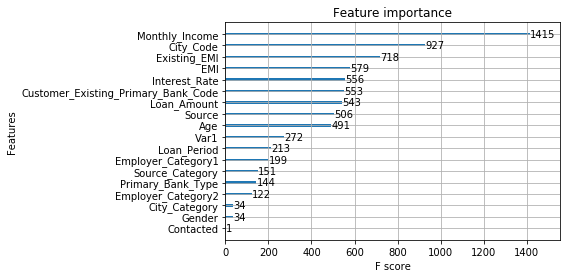

In [8]:
# feature importances
xgb.plot_importance(model)

In [9]:
# Get test predictions
test=pd.read_csv('prepped_test.csv')
X_test=test.drop(['ID','Approved'],axis=1)
xgtest=xgb.DMatrix(X_test,feature_names=X_test.columns)
predictions=model.predict(xgtest)